In [1]:
# This file is for answering question 7. 

# reward of draw = 1
# reward of checkmate = -1
# punishment of steps = 0


These two files 'gradient_exploding' and 'gradient_exploding_clipping' are preparing for a comparison experiment to solve gradient exploding problem.

We finally decided to set gamma = 0.85 and beta = 0.00005(the original parameter) because the result and plot is more clearer.

In [2]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *

# Changed to a new environment
from Chess_env_reward_change import *


size_board = 4
# ---------------------------------------------------- 

r_checkmate = 1              # reward of checkmate
r_draw = -1                   # reward of draw
p_step = 0                   # punishment of every step !!!

# ----------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
def EMA(arr,period=500):    ## Function for computing exponential moving average
    df = pd.DataFrame(arr)
    return df.ewm(span=period,min_periods=period).mean()

## Global_norm gradient clipping

Here we exploit global norm gradient clipping method to solve gradient exploding problems.
<img style="float: center;" src="global_norm.png" width="60%">

In [5]:
# global norm
def clip_grad_by_global_norm(grad, max_norm, norm_type=2):
    global_norm = np.linalg.norm(
        np.stack([np.linalg.norm(g.ravel(), ord=norm_type) for g in grad]).ravel(),
        ord=norm_type,
    )
    clip_coef = max_norm / (global_norm + 1e-6)
    if clip_coef > 1:
        clip_coef = 1
    normed_grad = []
    for g in grad:
        g = g * clip_coef
        normed_grad.append(g)
    normed_grad = np.array(normed_grad)
    return normed_grad

## Define parameters and nueral network

In [3]:
## INITIALISE THE ENVIRONMENT
np.random.seed(1)
env=Chess_Env(size_board, r_checkmate, r_draw, p_step)

In [4]:
S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS (OUPUT SIZE)
N_in=np.shape(X)[0]    ## INPUT SIZE

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 


In [6]:
# Define our neural network, which can be a three-layers or a four-layers network, by changing the variable [N_h2].
# Including initialize network, forward to compute q values and propagate to update neural network

class Neural_network: 
    def __init__(self):
        self.Xavier_init=True
        self.N_h=200               ## NUMBER OF HIDDEN NODES
        self.N_h2=100              ## NUMBER OF HIDDEN 2 NODES(set this to 0 if only need one hidden layer)
        self.N_a=32                ## OUTPUT SIZE
        self.N_in=58               ## INPUT SIZE (change this if change state representation)
        self.eta=0.0035            ## THE LEARNING RATE

    def parameter_init(self):      #INITIALIZE W PARAMETER
        if self.Xavier_init:       #USE XAVIER INITIALIZATION METHOD
            self.W1 = np.random.randn(self.N_h, self.N_in) * np.sqrt(1 / (self.N_in))
            if self.N_h2>0:
                self.W2 = np.random.randn(self.N_h2, self.N_h) * np.sqrt(1 / (self.N_h))
                self.W3 = np.random.randn(self.N_a, self.N_h2) * np.sqrt(1 / (self.N_h2))
            else:
                self.W2 = np.random.randn(self.N_a, self.N_h) * np.sqrt(1 / (self.N_h))
        else:
            self.W1 = np.random.uniform(0,1,(self.N_h, self.N_in))
            self.W2 = np.random.uniform(0,1,(self.N_a, self.N_h))

            # The following normalises the random weights so that the sum of each row =1
            self.W1 = np.divide(self.W1,np.matlib.repmat(np.sum(self.W1,1)[:,None],1,self.N_in))
            self.W2 = np.divide(self.W2,np.matlib.repmat(np.sum(self.W2,1)[:,None],1,self.N_h))

            if self.N_h2>0:
                self.W3=np.random.uniform(0,1,(self.N_a,self.N_h2))
                self.W3=np.divide(self.W3,np.matlib.repmat(np.sum(self.W3,1)[:,None],1,self.N_h2))

                self.W2=np.random.uniform(0,1,(self.N_h2,self.N_h))
                self.W2=np.divide(self.W2,np.matlib.repmat(np.sum(self.W2,1)[:,None],1,self.N_h))
                
    def biases_init(self):    # INITIALIZE BIAS PARAMETER
        self.bias_W1 = np.zeros((self.N_h,))
        self.bias_W2 = np.zeros((self.N_a,))

        if self.N_h2>0:    
            self.bias_W3=np.zeros((self.N_a,))
            self.bias_W2=np.zeros((self.N_h2,))

    def predict(self,X):     # COMPUTE Q VALUES

            # Neural activation: input layer -> hidden layer
            self.h1 = np.dot(self.W1,X)+self.bias_W1

            # Apply the leaky relu function
            self.x1=np.where(self.h1>0,self.h1,0.01*self.h1)

            # Neural activation: hidden layer -> output layer
            self.h2 = np.dot(self.W2,self.x1)+self.bias_W2

            # Apply the leaky relu function
            self.x2=np.where(self.h2>0,self.h2,0.01*self.h2)

            if self.N_h2 > 0:
                # Neural activation: hidden layer 1 -> hidden layer 2
                self.h3 = np.dot(self.W3,self.x2)+self.bias_W3
                self.q_values = np.where(self.h3>0,self.h3,0.01*self.h3)

            else:
                self.q_values=self.x2

            return self.q_values
            
    def update(self,delta,a,X):    # BACKWARD PROPAGATION
        # Initialise the gradients for each batch
        self.dW1 = np.zeros(self.W1.shape)
        self.dW2 = np.zeros(self.W2.shape)

        self.dbias_W1 = np.zeros(self.bias_W1.shape)
        self.dbias_W2 = np.zeros(self.bias_W2.shape)

        if self.N_h2 > 0:
            self.dW3 = np.zeros(self.W3.shape)
            self.dbias_W3 = np.zeros(self.bias_W3.shape)
            
        # Backpropagation
        if self.N_h2 > 0:
            self.delta3 = np.zeros(self.N_a)
            self.delta3[a] = delta # only the action nueron
            
            # Backpropagation: output layer -> hidden layer 2
            self.dW3 = np.outer(self.delta3,self.x2)
            self.dbias_W3 = self.delta3

            # Backpropagation: hidden layer 2 -> hidden layer 1
            self.delta2 = np.dot(self.W3.T, self.delta3)

        else:   
            self.delta2 = np.zeros(self.N_a)
            self.delta2[a] = delta
        
        # Backpropagation: output layer -> hidden layer 1
        self.dW2 = np.outer(self.delta2, self.x1)
        self.dbias_W2 = self.delta2

        # Backpropagation: hidden layer -> input layer
        self.delta1 = np.dot(self.W2.T, self.delta2)
        self.dW1 = np.outer(self.delta1,X)
        self.dbias_W1 = self.delta1
        
        # gradient clipping
        self.dW1 = clip_grad_by_global_norm(self.dW1, 1)
        self.dW2 = clip_grad_by_global_norm(self.dW2, 1)

        # update the weights using gradients
        self.W2 += self.eta*self.dW2
        self.W1 += self.eta*self.dW1

        self.bias_W1 += self.eta*self.dbias_W1
        self.bias_W2 += self.eta*self.dbias_W2

        if self.N_h2 > 0:
            self.W3 += self.eta*self.dW3
            self.bias_W3 += self.eta*self.dbias_W3
        

## SARSA - Reward Change

In [7]:
# Function training network using SARSA rule
def train_model(X,action,reward,next_state,next_action,done): 
    q_values = model.predict(X)
    if done:
        delta=reward-q_values[action]
    else:
        delta=reward+gamma*model.predict(next_state)[next_action]-q_values[action] # sarsa update rule
    
    l=delta*delta
    # Update the weights
    model.update(delta,action,X)
    return l

In [8]:
# Function choosing action according to epsilon greedy policy
def get_action(X,a):      # X: current state; a: possible actions in the current state
    if np.random.rand() <= epsilon_f:   # choosing action randomly
        a_agent=np.random.permutation(a)[0]
    else:
        q_values = model.predict(X)     # Predict Q value based on given state
        Qvalues = np.copy(q_values[a])  # only the possible actions in the current state
        a_max = np.argmax(Qvalues)      # choose the action with max Q value
        a_agent = np.copy(a[a_max])     # return the index of action
    return a_agent

In [9]:
# TRAINING LOOP

# INIALIZE THE NUERAL NETWORK WE USE
model=Neural_network()
model.parameter_init()
model.biases_init()

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])           ## STORE THE REWARD PER GAME
N_moves_save = np.zeros([N_episodes, 1])     ## STOR THE NUMBER OF MOVES PER GAME
N_checkmate_save = np.zeros([N_episodes, 1]) ## STOR THE checkmate case for counting the rate of it

for n in range(N_episodes):
    if n % 1000 == 0:
        print("Episodes:", n)

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME (S: CHESSBOARD; X:STATE; ALLOWED_A: POSSIBLE ACTIONS)
    
    while Done==0:                           ## START THE EPISODE
        
        
        a,_=np.where(allowed_a==1)           ## THE POSSIBLE ACTIONS IN THE CURRENT STATE
        a_agent = get_action(X,a)            ## CHOOSE A ACTION
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)  ## IMPLEMENT THE ACTION


        ## THE EPISODE HAS ENDED, UPDATE
        if Done==1:
            
            R_save[n]=np.copy(R)             ## STORE THE REWARD
            N_moves_save[n]=np.copy(i)       ## STORE THE NUMBER OF MOVES
            
            # ------------------------------------------------
            N_checkmate_save[n] = np.copy(env.is_checkmate)  ## STORE THE WIN or DRAW CASE
            # ------------------------------------------------
            
            next_a_agent=0                   ## SET THIS TO 0 AS NO NEXT ACTION NEEDED
            train_model(X,a_agent,R,X_next,next_a_agent,Done)  ## TRAIN MODEL AND UPDATE PARAMETER
            break    
        
        # IF THE EPISODE IS NOT OVER...
        else:
            a_next,_=np.where(allowed_a_next==1)              ## THE POSSIBLE NEXT ACTIONS IN THE NEXT STATE
            next_a_agent = get_action(X_next,a_next)          ## CHOOSE A ACTION FOR NEXT STATE
            train_model(X,a_agent,R,X_next,next_a_agent,Done) ## TRAIN MODEL AND UPDATE PARAMETER
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)                                     
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

print('Deep_sarsa_Agent, Average reward:',np.mean(R_save),
      'Number of steps: ',np.mean(N_moves_save),
      'Number of checkmates: ',np.mean(N_checkmate_save))

Episodes: 0
Episodes: 1000
Episodes: 2000
Episodes: 3000
Episodes: 4000
Episodes: 5000
Episodes: 6000
Episodes: 7000
Episodes: 8000
Episodes: 9000
Episodes: 10000
Episodes: 11000
Episodes: 12000
Episodes: 13000
Episodes: 14000
Episodes: 15000
Episodes: 16000
Episodes: 17000
Episodes: 18000
Episodes: 19000
Episodes: 20000
Episodes: 21000
Episodes: 22000
Episodes: 23000
Episodes: 24000
Episodes: 25000
Episodes: 26000
Episodes: 27000
Episodes: 28000
Episodes: 29000
Episodes: 30000
Episodes: 31000
Episodes: 32000
Episodes: 33000
Episodes: 34000
Episodes: 35000
Episodes: 36000
Episodes: 37000
Episodes: 38000
Episodes: 39000
Episodes: 40000
Episodes: 41000
Episodes: 42000
Episodes: 43000
Episodes: 44000
Episodes: 45000
Episodes: 46000
Episodes: 47000
Episodes: 48000
Episodes: 49000
Episodes: 50000
Episodes: 51000
Episodes: 52000
Episodes: 53000
Episodes: 54000
Episodes: 55000
Episodes: 56000
Episodes: 57000
Episodes: 58000
Episodes: 59000
Episodes: 60000
Episodes: 61000
Episodes: 62000
Episo

In [10]:
g=pd.DataFrame()
g['R_save']=R_save.reshape(N_episodes)
g['N_moves_save']=N_moves_save.reshape(N_episodes)
g['N_checkmate_save']=N_checkmate_save.reshape(N_episodes)
g.to_excel(r'gradient_exploding_clipping.xlsx',encoding='utf-8',index=False)

In [11]:
re=pd.read_excel(r'gradient_exploding_clipping.xlsx')

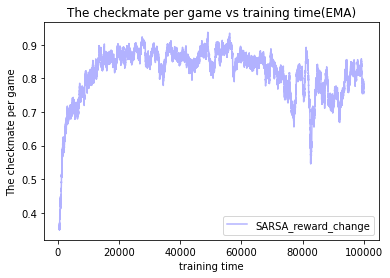

In [12]:
plt.plot(range(N_episodes), EMA(re['N_checkmate_save']),c='blue',alpha=0.3,label='SARSA_reward_change')
plt.legend()
plt.title('The checkmate per game vs training time(EMA)')
plt.xlabel('training time')
plt.ylabel('The checkmate per game')
plt.show()

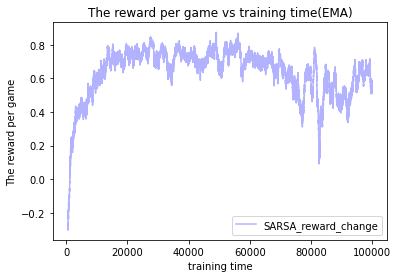

In [13]:
plt.plot(range(N_episodes), EMA(re['R_save']),c='blue',alpha=0.3,label='SARSA_reward_change')
plt.legend()
plt.title('The reward per game vs training time(EMA)')
plt.xlabel('training time')
plt.ylabel('The reward per game')
plt.show()

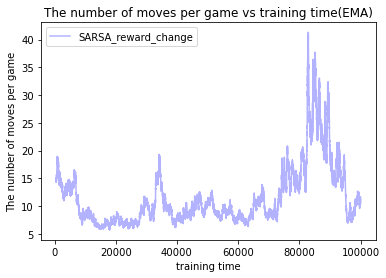

In [14]:
plt.plot(range(N_episodes), EMA(re['N_moves_save']),c='b',alpha=0.3,label='SARSA_reward_change')
plt.legend()
plt.title('The number of moves per game vs training time(EMA)')
plt.xlabel('training time')
plt.ylabel('The number of moves per game')
plt.show()